Problem Statement : Ola Cabs (stylized as OLΛ) is an Indian multinational ridesharing company, headquartered in Bangalore. It also operates in other business verticals including financial services and cloud kitchens.
Like every other business, OLA also has competitors and it’s very easy for drivers to stop working for the service on the fly or jump to other ride sharing apps depending on the rates.
In this case study we going to study the driver team attrition and help OLA understand the pattern based on various features and predict what drivers are likely to stay back with the app and who are likely to leave. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer

In [3]:
ola = pd.read_csv('C:/DSML/OLA - Case study/OLA.csv')

In [4]:
ola.shape

(19104, 14)

In [5]:
ola.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,1/1/2019,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,2/1/2019,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,3/1/2019,1,28.0,0.0,C23,2,57387,24/12/18,3/11/2019,1,1,0,2
3,3,11/1/2020,2,31.0,0.0,C7,2,67016,11/6/2020,NaN,2,2,0,1
4,4,12/1/2020,2,31.0,0.0,C7,2,67016,11/6/2020,NaN,2,2,0,1


In [6]:
ola.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [7]:
ola.dtypes

Unnamed: 0                int64
MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object

Now let us convert the date like features to standard date time data type so that we can make meaningful analysis on them

In [8]:
ola['MMM-YY'] = ola['MMM-YY'].astype('datetime64')
ola['Dateofjoining'] = ola['Dateofjoining'].astype('datetime64')

# Missing value detection

In [9]:
ola.isna().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

# Missing value treatment

# KNN Imputation

In [10]:
ola_1 = ola[['Age','Gender']]

In [11]:
imputer = KNNImputer(n_neighbors=5)
imputation = imputer.fit_transform(ola_1)
ola_1 = pd.DataFrame(imputation)

In [12]:
ola['Age'] = ola_1[0]
ola['Gender'] = ola_1[1]

In [13]:
ola.isna().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

# Feature engineering

In [14]:
ola = ola.sort_values(by=['Driver_ID','MMM-YY'])

In [15]:
segment_dict1 = {
    'Quarterly Rating' : 'first'
    
}

segment_dict2 = {
    'Quarterly Rating' : 'last'
}

segment_1 = ola.groupby('Driver_ID').agg(segment_dict1).reset_index()
segment_2 = ola.groupby('Driver_ID').agg(segment_dict2).reset_index()
segment_2['Rating change'] = segment_2['Quarterly Rating'] - segment_1['Quarterly Rating']
segment_2[[segment_2['Rating change'] < 0] or [segment_2['Rating change'] == 0]] = 0
segment_2.drop('Quarterly Rating',axis=1,inplace=True)

In [16]:
ola = ola.sort_values(by=['Driver_ID','MMM-YY'])

In [17]:
segment_dict3 = {
    'Income' : 'first'
    
}

segment_dict4 = {
    'Income' : 'last'
}

segment_3 = ola.groupby('Driver_ID').agg(segment_dict3).reset_index()
segment_4 = ola.groupby('Driver_ID').agg(segment_dict4).reset_index()
segment_4['Income_change'] = segment_4['Income'] - segment_3['Income']
segment_4[[segment_4['Income_change'] < 0] or [segment_4['Income_change'] == 0]] = 0
segment_4.drop('Income',axis=1,inplace=True)

# Aggregation of data

In [18]:
ola['target'] = ola['LastWorkingDate']
ola['target'].fillna(0,inplace=True)
ola.loc[ola['target'] != 0,'target'] = 1

In [19]:
#aggregating the total business value for each driver
ola['total business'] = ola.groupby('Driver_ID')['Total Business Value'].cumsum()

In [20]:
segment_dict = {
    'Age' : 'last',
    'Gender' : 'last',
    'City' : 'last',
    'Education_Level' : 'last',
    'Income' : 'last',
    'Joining Designation' : 'last',
    'Dateofjoining' : 'last',
    'LastWorkingDate' : 'last',
    'Grade' : 'last',
    'total business' : 'last',
    'Quarterly Rating' : 'last',
    'target' : 'last'
    
}

In [21]:
ola_1 = ola.groupby('Driver_ID').agg(segment_dict).reset_index()
ola_1

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Dateofjoining,LastWorkingDate,Grade,total business,Quarterly Rating,target
0,1,28.0,0.0,C23,2,57387,1,2018-12-24,3/11/2019,1,1715580,2,1
1,2,31.0,0.0,C7,2,67016,2,2020-11-06,None,2,0,1,0
2,4,43.0,0.0,C13,2,65603,2,2019-12-07,27/04/20,2,350000,1,1
3,5,29.0,0.0,C9,0,46368,1,2019-01-09,3/7/2019,1,120360,1,1
4,6,31.0,1.0,C11,1,78728,3,2020-07-31,None,3,1265000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34.0,0.0,C24,0,82815,2,2015-10-15,None,3,21748820,4,0
2377,2785,34.0,1.0,C9,0,12105,1,2020-08-28,28/10/20,1,0,1,1
2378,2786,45.0,0.0,C19,0,35370,2,2018-07-31,22/09/19,2,2815090,1,1
2379,2787,28.0,1.0,C20,2,69498,1,2018-07-21,20/06/19,1,977830,1,1


In [22]:
#merge the main dataframe with segment 2 to know if there is Quarterly Rating change
ola_1 = pd.merge(ola_1, segment_2, on = "Driver_ID", how = "inner")

In [23]:
#merge the main dataframe with segment 4 to know if there is monthly income change
ola_1 = pd.merge(ola_1, segment_4, on = "Driver_ID", how = "inner")

In [24]:
ola_1

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Dateofjoining,LastWorkingDate,Grade,total business,Quarterly Rating,target,Rating change,Income_change
0,1,28.0,0.0,C23,2,57387,1,2018-12-24,3/11/2019,1,1715580,2,1,0,0
1,2,31.0,0.0,C7,2,67016,2,2020-11-06,None,2,0,1,0,0,0
2,4,43.0,0.0,C13,2,65603,2,2019-12-07,27/04/20,2,350000,1,1,0,0
3,5,29.0,0.0,C9,0,46368,1,2019-01-09,3/7/2019,1,120360,1,1,0,0
4,6,31.0,1.0,C11,1,78728,3,2020-07-31,None,3,1265000,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,2781,25.0,0.0,C23,2,46952,2,2020-02-17,None,2,8633370,4,0,3,0
1919,2782,26.0,0.0,C19,1,29582,1,2019-05-16,16/08/19,1,0,1,1,0,0
1920,2784,34.0,0.0,C24,0,82815,2,2015-10-15,None,3,21748820,4,0,1,0
1921,2785,34.0,1.0,C9,0,12105,1,2020-08-28,28/10/20,1,0,1,1,0,0


# Statistical summary

In [25]:
ola_1.dtypes

Driver_ID                       int64
Age                           float64
Gender                        float64
City                           object
Education_Level                 int64
Income                          int64
Joining Designation             int64
Dateofjoining          datetime64[ns]
LastWorkingDate                object
Grade                           int64
total business                  int64
Quarterly Rating                int64
target                          int64
Rating change                   int64
Income_change                   int64
dtype: object

In [26]:
ola_stat = ola_1[['Age','Gender','Education_Level','Income','Joining Designation','Grade','total business','Quarterly Rating','target','Rating change','Income_change']]

In [27]:
ola_stat.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,total business,Quarterly Rating,target,Rating change,Income_change
count,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1.923000e+03,1923.000000,1923.000000,1923.000000,1923.000000
mean,33.321165,0.417057,0.982319,58362.785751,1.910036,2.103484,3.421728e+06,1.475299,0.647426,0.271451,87.202288
std,5.677748,0.493201,0.819697,27455.951801,0.853296,0.910228,7.871350e+06,0.861229,0.477896,0.640427,768.283693
min,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.000000,38595.500000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,1.000000,55108.000000,2.000000,2.000000,3.500000e+05,1.000000,1.000000,0.000000,0.000000
75%,37.000000,1.000000,2.000000,74809.000000,3.000000,3.000000,2.274815e+06,2.000000,1.000000,0.000000,0.000000
max,58.000000,1.000000,2.000000,167758.000000,5.000000,5.000000,9.533106e+07,4.000000,1.000000,3.000000,9327.000000


# Univariate Analysis

<AxesSubplot:xlabel='target', ylabel='Count'>

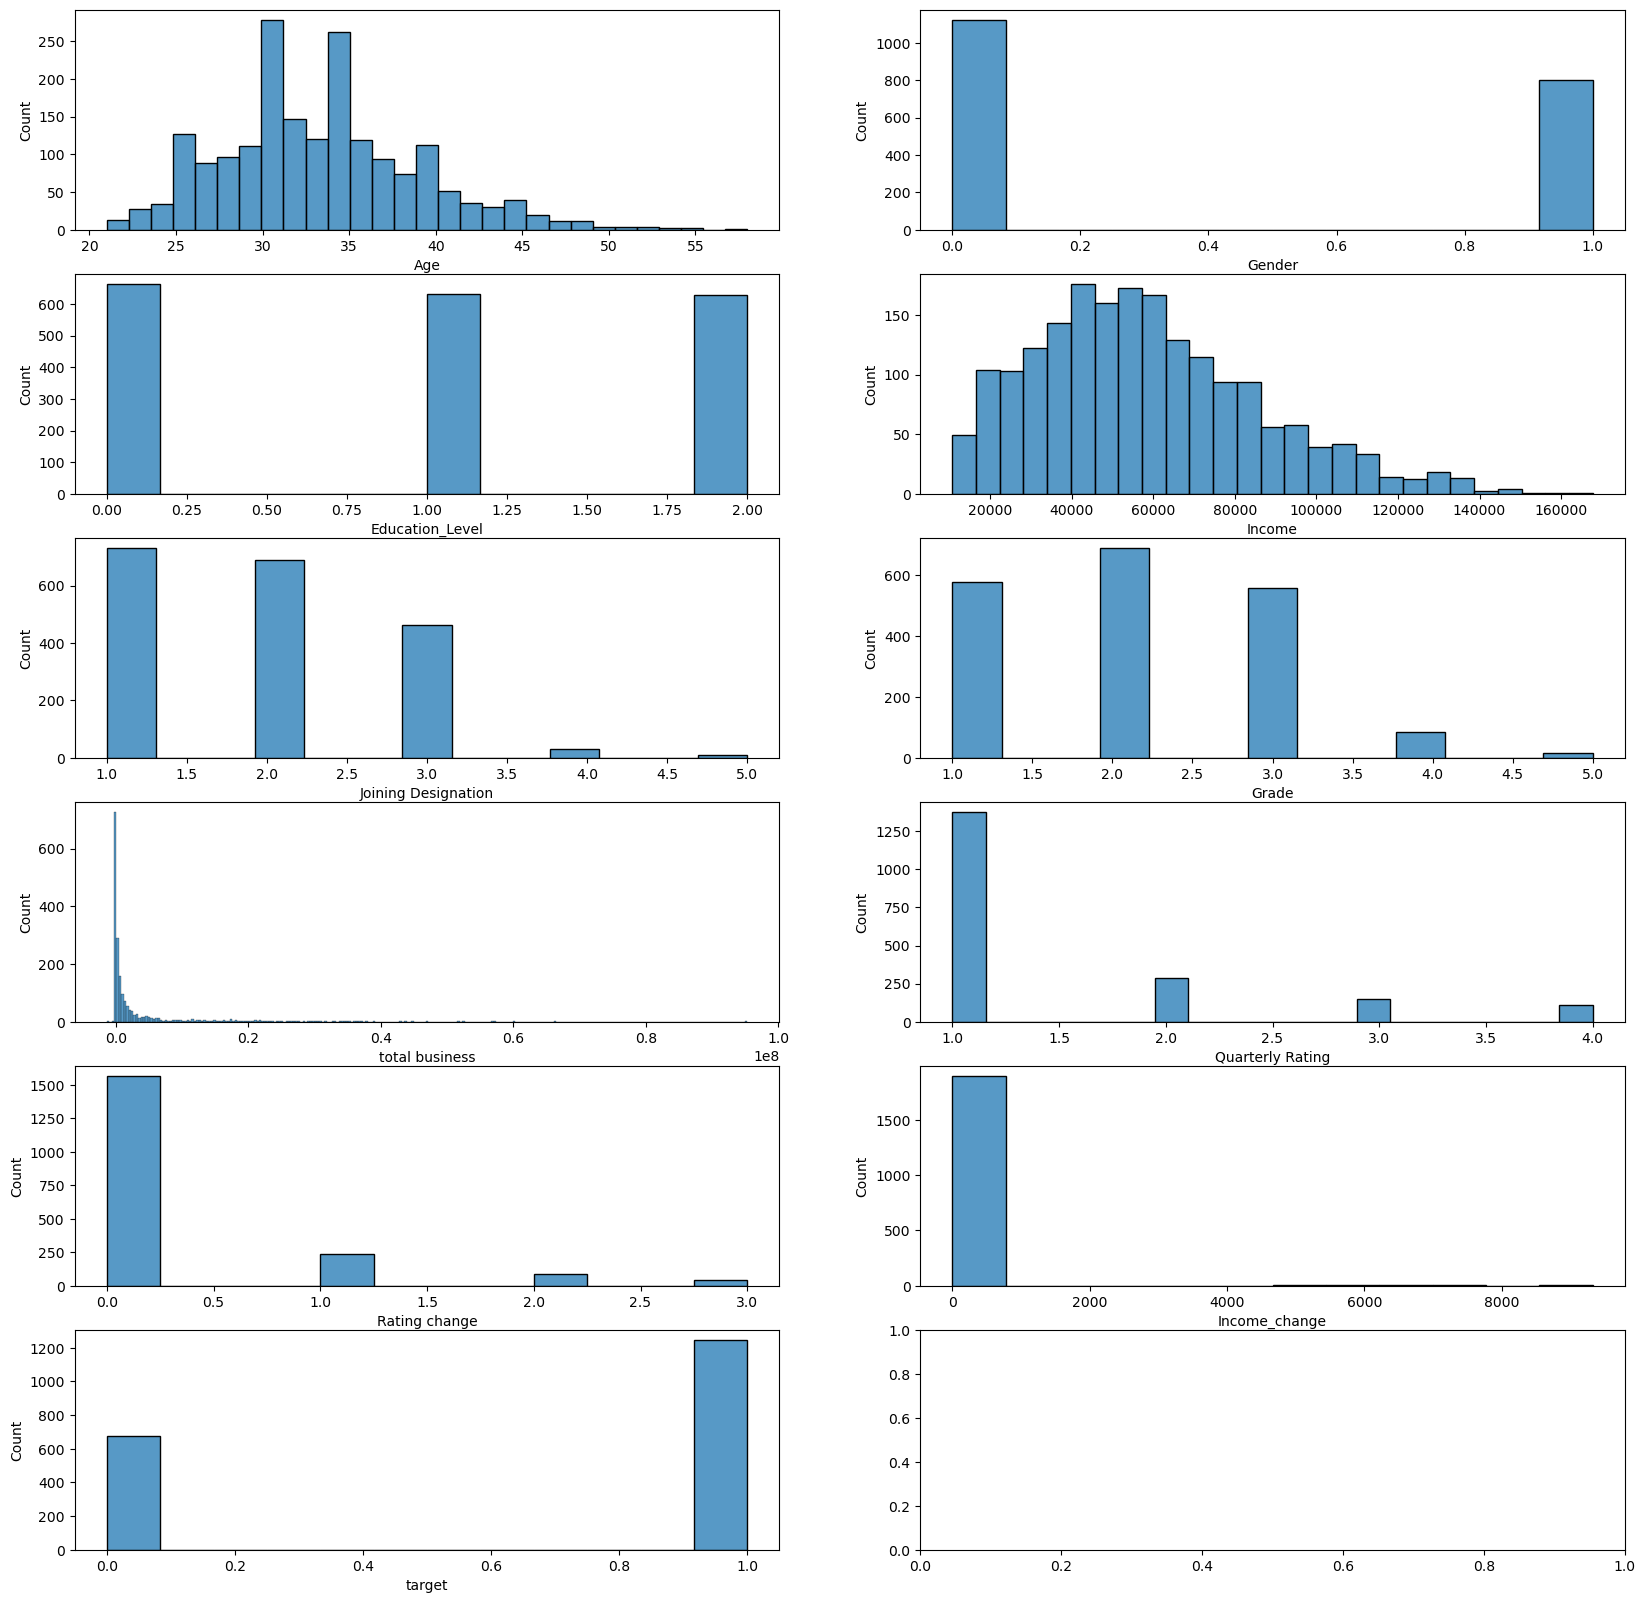

In [28]:
# Histogram plot for continuous variables to visualize their distribution
fig, axis = plt.subplots(nrows=6, ncols=2, figsize=(20, 20))
sns.histplot(x = 'Age',data = ola_1,ax=axis[0,0])
sns.histplot(x = 'Gender',data = ola_1,ax=axis[0,1])
sns.histplot(x = 'Education_Level',data = ola_1,ax=axis[1,0])
sns.histplot(x = 'Income',data = ola_1,ax=axis[1,1])
sns.histplot(x = 'Joining Designation',data = ola_1,ax=axis[2,0])
sns.histplot(x = 'Grade',data = ola_1,ax=axis[2,1])
sns.histplot(x = 'total business',data = ola_1,ax=axis[3,0])
sns.histplot(x = 'Quarterly Rating',data = ola_1,ax=axis[3,1])
sns.histplot(x = 'Rating change',data = ola_1,ax=axis[4,0])
sns.histplot(x = 'Income_change',data = ola_1,ax=axis[4,1])
sns.histplot(x = 'target',data = ola_1,ax=axis[5,0])

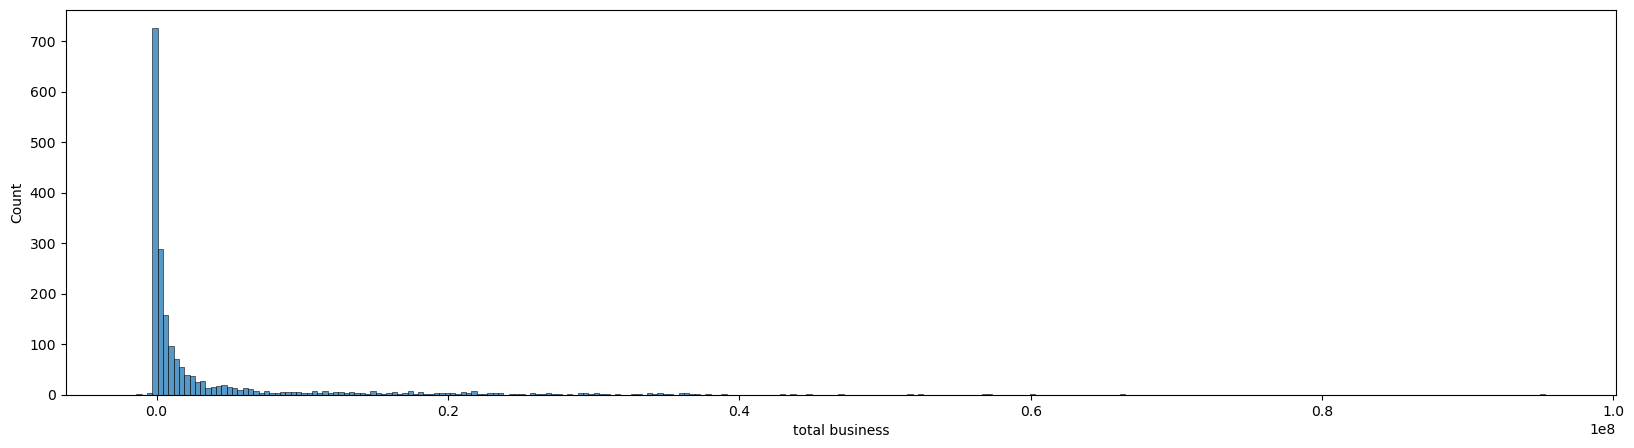

In [29]:
hstplot, ax = plt.subplots(figsize = (20,5))
ax =sns.histplot(x = 'total business', data=ola_1)

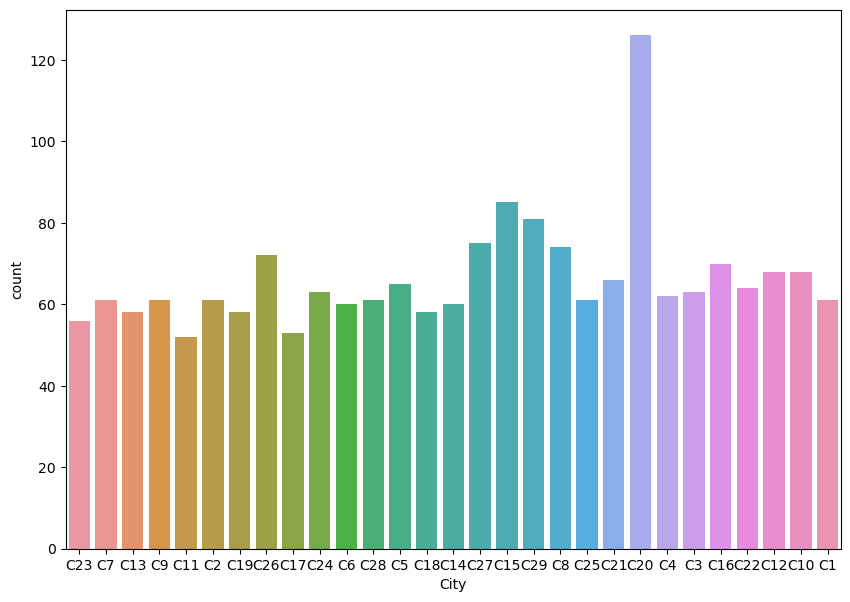

In [30]:
# countplot to demonstrate the distribution of categorical variables
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x = 'City', data=ola_1)

# Bivariate Analysis

<AxesSubplot:xlabel='target', ylabel='target'>

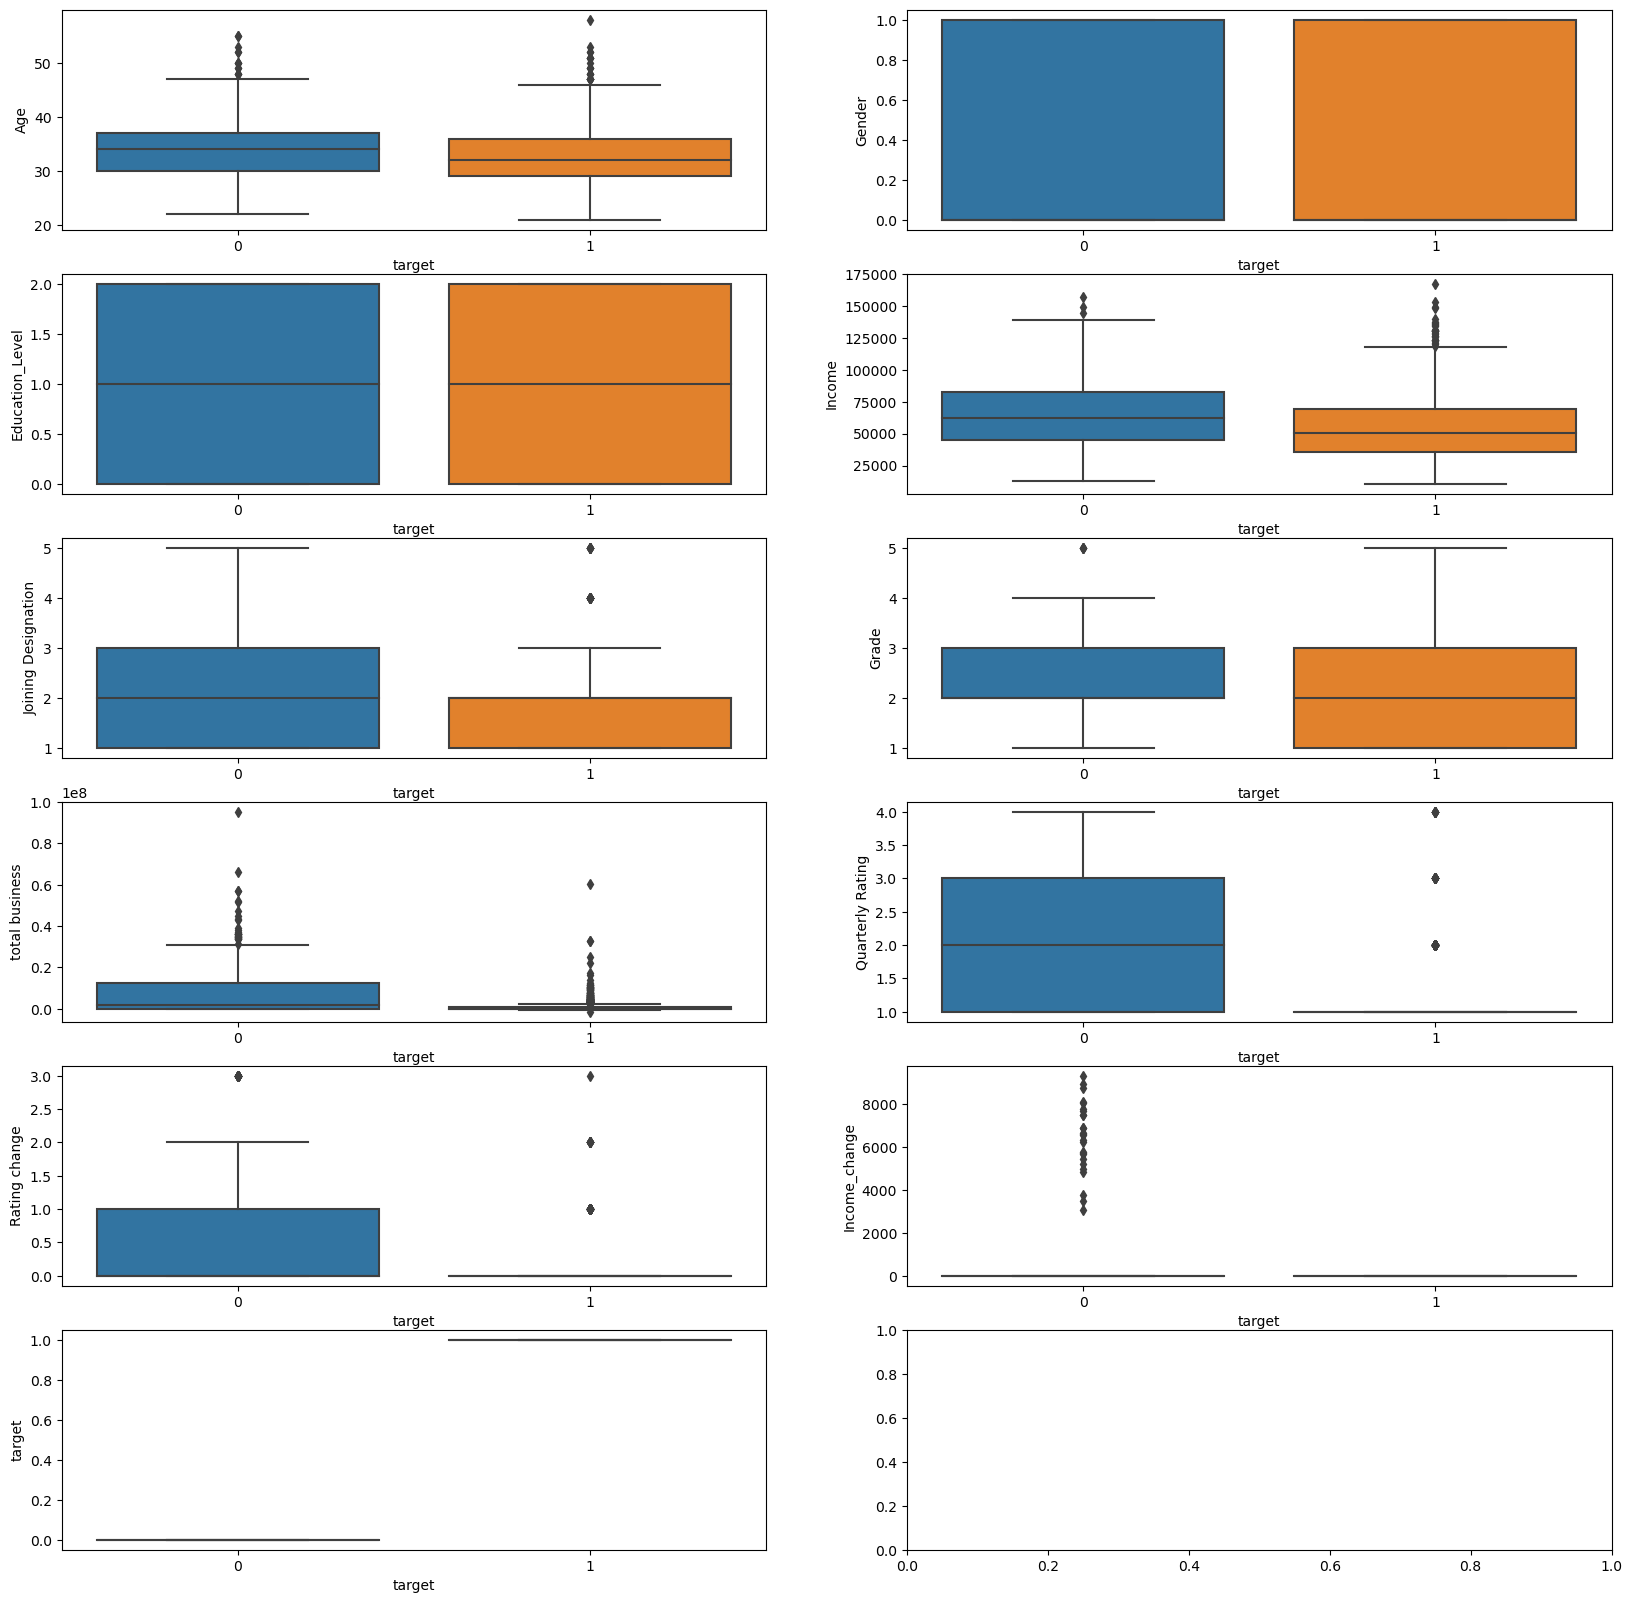

In [31]:
fig, axis = plt.subplots(nrows=6, ncols=2, figsize=(20, 20))
sns.boxplot(y = 'Age',x = 'target',data=ola_1,ax=axis[0,0])
sns.boxplot(y = 'Gender',x = 'target',data=ola_1,ax=axis[0,1])
sns.boxplot(y = 'Education_Level',x = 'target',data=ola_1,ax=axis[1,0])
sns.boxplot(y = 'Income',x = 'target',data=ola_1,ax=axis[1,1])
sns.boxplot(y = 'Joining Designation',x = 'target',data=ola_1,ax=axis[2,0])
sns.boxplot(y = 'Grade',x = 'target',data=ola_1,ax=axis[2,1])
sns.boxplot(y = 'total business',x = 'target',data=ola_1,ax=axis[3,0])
sns.boxplot(y = 'Quarterly Rating',x = 'target',data=ola_1,ax=axis[3,1])
sns.boxplot(y = 'Rating change',x = 'target',data=ola_1,ax=axis[4,0])
sns.boxplot(y = 'Income_change',x = 'target',data=ola_1,ax=axis[4,1])
sns.boxplot(y = 'target',x = 'target',data=ola_1,ax=axis[5,0])

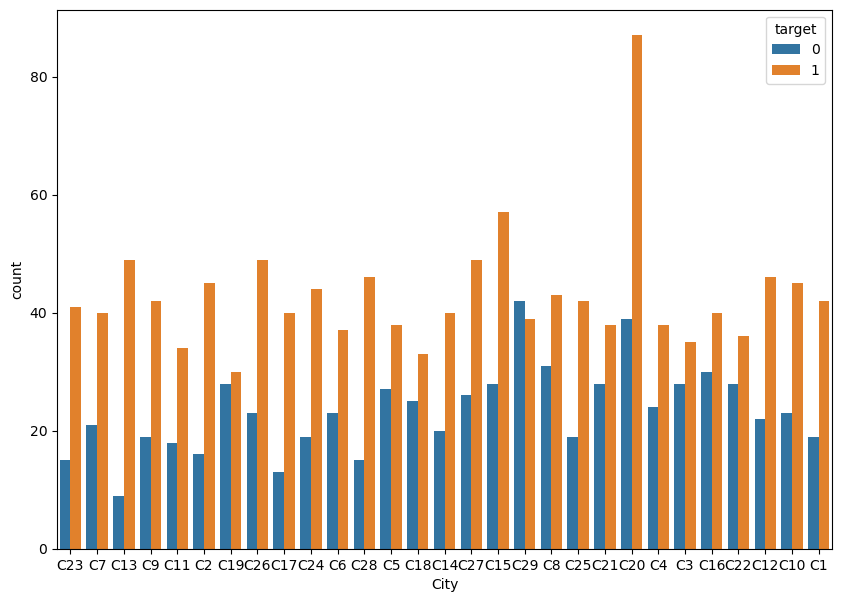

In [32]:
#
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x = 'City', hue='target', data=ola_1)

# Correlation among independent variables

In [33]:
x_corr = ola_1.drop('target',axis=1)

In [34]:
x_corr.corr()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,total business,Quarterly Rating,Rating change,Income_change
Driver_ID,1.000000,-0.003225,0.022768,0.008698,-0.010248,-0.001744,-0.006286,0.018693,0.017682,-0.004093,0.009312
Age,-0.003225,1.000000,0.019031,-0.020065,0.208237,0.132775,0.269696,0.251065,0.182337,0.067759,0.116095
Gender,0.022768,0.019031,1.000000,-0.015212,0.007155,-0.043084,-0.015060,0.018123,0.024266,0.025197,0.028288
Education_Level,0.008698,-0.020065,-0.015212,1.000000,0.137640,0.019297,-0.011493,-0.007893,0.019280,0.031943,-0.018861
Income,-0.010248,0.208237,0.007155,0.137640,1.000000,0.546524,0.721554,0.293881,0.179399,0.142856,0.067958
Joining Designation,-0.001744,0.132775,-0.043084,0.019297,0.546524,1.000000,0.793742,-0.088319,-0.088338,0.041855,-0.087212
Grade,-0.006286,0.269696,-0.015060,-0.011493,0.721554,0.793742,1.000000,0.300990,0.119080,0.108873,0.095304
total business,0.018693,0.251065,0.018123,-0.007893,0.293881,-0.088319,0.300990,1.000000,0.679053,0.366479,0.389425
Quarterly Rating,0.017682,0.182337,0.024266,0.019280,0.179399,-0.088338,0.119080,0.679053,1.000000,0.761158,0.292373
Rating change,-0.004093,0.067759,0.025197,0.031943,0.142856,0.041855,0.108873,0.366479,0.761158,1.000000,0.135492


In [35]:
ola_stat1 = ola_1[['Age','Gender','Education_Level','Income','Grade','total business','Quarterly Rating','Grade','Joining Designation']]

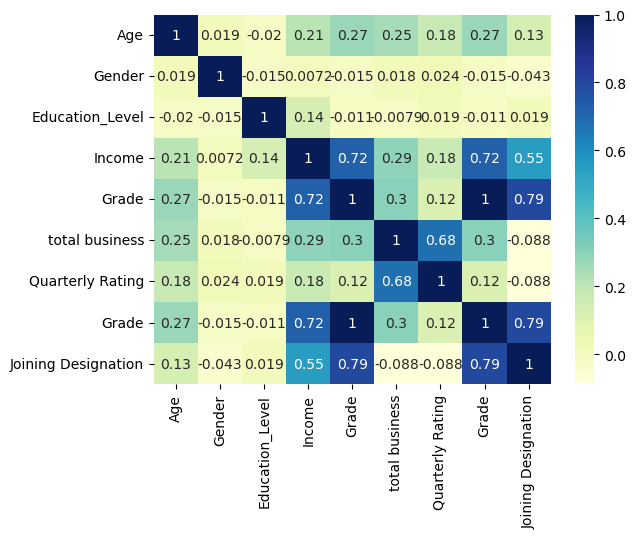

In [36]:
dataplot = sns.heatmap(ola_stat1.corr(), cmap="YlGnBu", annot=True)

# Encoding

In [37]:
te = TargetEncoder()
ola_1['City'] = te.fit_transform(ola_1['City'], ola_1['target'])
ola_1['City'].value_counts()

0.687855    183
0.690475    126
0.670553     85
0.481853     81
0.653309     75
0.581379     74
0.680374     72
0.571937     70
0.661648     68
0.676234     68
0.576471     66
0.585305     65
0.563530     64
0.697730     63
0.556785     63
0.613413     62
0.752359     61
0.655602     61
0.736233     61
0.666321     60
0.617220     60
0.570682     58
0.520090     58
0.840508     58
0.729890     56
0.750901     53
0.653595     52
Name: City, dtype: int64

# Data split

In [38]:
X = ola_1[['Age','Gender','Education_Level','Income','Joining Designation','Grade','total business','Quarterly Rating','Rating change','Income_change']]

In [39]:
Y = ola_1['target']
Y = np.array(Y).reshape(len(Y), 1)

# Scaling

In [40]:
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

# Class Imbalance Treatment

In [41]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smt = SMOTE()

# Perform SMOTE on the training data
print('Before SMOTE')
Y = pd.DataFrame(Y)
print(Y.value_counts())

X_sm, y_sm = smt.fit_resample(X, Y)
print('After Oversampling')
y_sm1 = pd.DataFrame(y_sm)
print(y_sm1.value_counts())

Before SMOTE
1    1245
0     678
dtype: int64
After Oversampling
0    1245
1    1245
dtype: int64


# Model Building

# ensemble - Bagging algorithm - Random Forest Classifier

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=1)

In [43]:
# Defining parameters for hyperparameter tuning-

params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10,11]
         }

In [44]:
# Use Random Search CV to get the best fitting hyperparameters for our bagging algorithm i.e Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt

rfc = RFC()
clf = RandomizedSearchCV(rfc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\pgpra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pgpra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pgpra\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\pgpra\Anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\pgpra\Anaconda3\lib\site-pa

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10],
                                        'max_features': [8, 9, 10, 11],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='accuracy', verbose=1)

In [45]:
# printing the best hyperparameters to be used to train our model
print(clf.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=3, max_features=8,
                       n_estimators=400)


In [46]:
# Training our model using the best hyperparameters
rfc = clf.best_estimator_

rfc.fit(X_train, y_train)

# Model accuracy of RFC
print("Model acc",rfc.score(X_test, y_test))

C:\Users\pgpra\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Model acc 0.7428571428571429


# ensemble - Boosting algorithm - GBDT

In [47]:
# Defining parameters for hyperparameter tuning-

params = {
    "n_estimators": [50,100,150,200],
    "max_depth" : [3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
    "learning_rate": [0.1, 0.2, 0.3]
}

In [48]:
# Use Random Search CV to get the best fitting hyperparameters for our boosting algorithm i.e Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt

gbc = GBC()
clf = RandomizedSearchCV(gbc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

clf.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\pgpra\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 7],
                                        'max_leaf_nodes': [20, 40, 80],
                                        'n_estimators': [50, 100, 150, 200]},
                   scoring='accuracy', verbose=1)

In [49]:
# printing the best hyperparameters to be used to train our model
print(clf.best_estimator_)

GradientBoostingClassifier(max_leaf_nodes=40)


In [50]:
# Training our model using the best hyperparameters
gbc = clf.best_estimator_

gbc.fit(X_train, y_train)

# Model accuracy of GBC
print("Model acc",gbc.score(X_test, y_test))

Model acc 0.7766233766233767


C:\Users\pgpra\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# ensemble - Boosting algorithm - XGBoost

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import datetime as dt

# Defining parameters for hyperparameter tuning-
params = {
        "n_estimators": [50,100,150,200],
        "max_depth" : [3, 4, 5, 7],
        "learning_rate": [0.1, 0.2, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        }

xgb = XGBClassifier()

In [52]:
# Use Random Search CV to get the best fitting hyperparameters for our boosting algorithm i.e XG Boost
random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=10,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   cv=3,
                                   verbose=2)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=

In [53]:
# printing the best hyperparameters to be used to train our model
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [54]:
# Training our model using the best hyperparameters
xgb = random_search.best_estimator_

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [55]:
# Model accuracy of RXGB
print("Model acc",xgb.score(X_test, y_test))

Model acc 0.7584415584415585


# Results Evaluation

# ROC AUC Curve

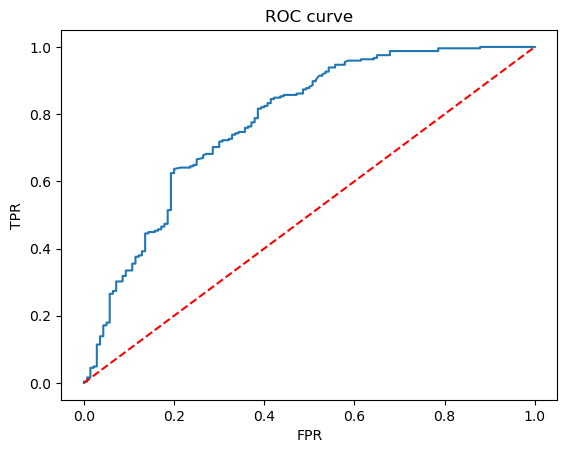

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
probability = rfc.predict_proba(X_test)
probabilites = probability[:,1]
fpr, tpr, thr = roc_curve(y_test,probabilites)

plt.plot(fpr,tpr)
#random model
plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [57]:
# ROC AUC score for RFC
roc_auc_score(y_test,probabilites)

0.7782069970845482

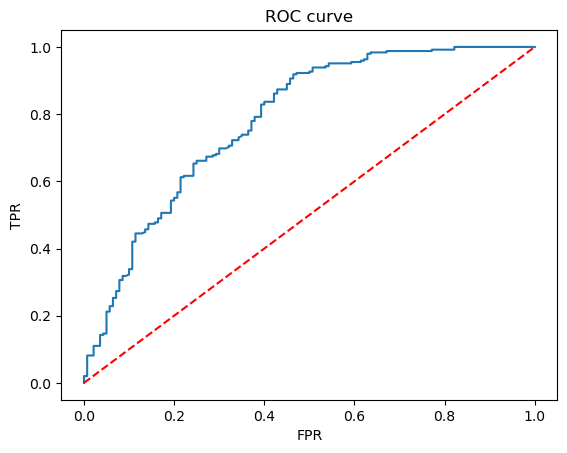

In [58]:
probability = gbc.predict_proba(X_test)
probabilites = probability[:,1]
fpr, tpr, thr = roc_curve(y_test,probabilites)

plt.plot(fpr,tpr)
#random model
plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [59]:
# ROC AUC score for GBC
roc_auc_score(y_test,probabilites)

0.782798833819242

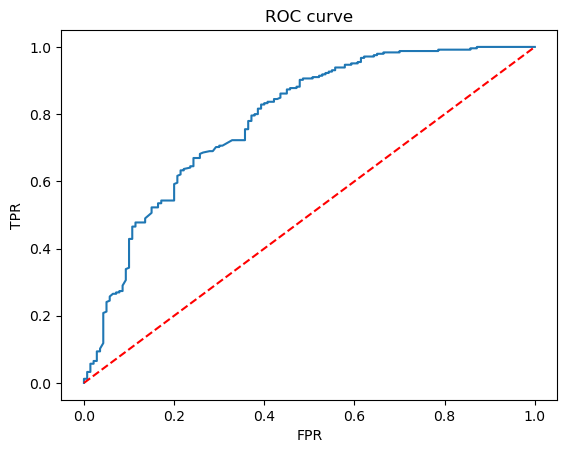

In [60]:
probability = xgb.predict_proba(X_test)
probabilites = probability[:,1]
fpr, tpr, thr = roc_curve(y_test,probabilites)

plt.plot(fpr,tpr)
#random model
plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [61]:
# ROC AUC score for XGB
roc_auc_score(y_test,probabilites)

0.7851603498542273

# Classification report

# Confusion Matrix and Classification Report for RFC

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rfc.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 72,  68],
       [ 31, 214]], dtype=int64)

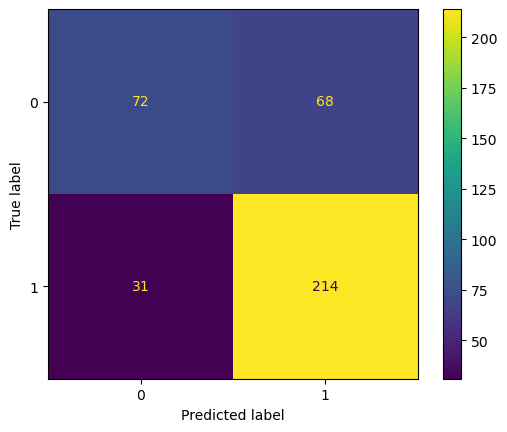

In [63]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [64]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59       140
           1       0.76      0.87      0.81       245

    accuracy                           0.74       385
   macro avg       0.73      0.69      0.70       385
weighted avg       0.74      0.74      0.73       385



# Confusion Matrix and Classification Report for GBC

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = gbc.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 74,  66],
       [ 20, 225]], dtype=int64)

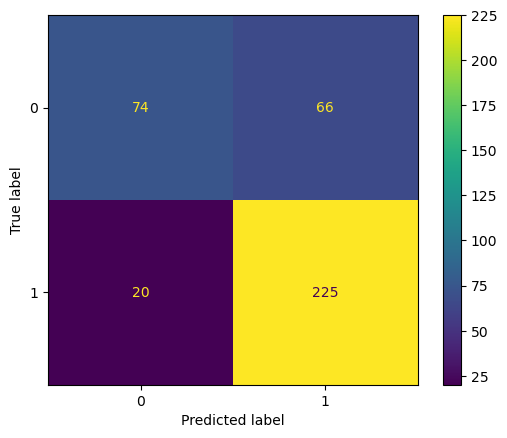

In [66]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [67]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.79      0.53      0.63       140
           1       0.77      0.92      0.84       245

    accuracy                           0.78       385
   macro avg       0.78      0.72      0.74       385
weighted avg       0.78      0.78      0.76       385



# Confusion Matrix and Classification Report for XGB

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 69,  71],
       [ 22, 223]], dtype=int64)

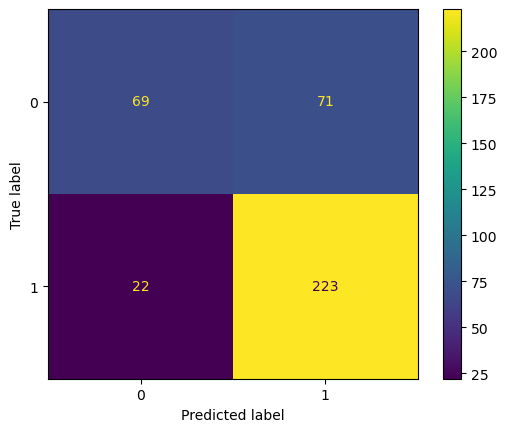

In [69]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [70]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.76      0.49      0.60       140
           1       0.76      0.91      0.83       245

    accuracy                           0.76       385
   macro avg       0.76      0.70      0.71       385
weighted avg       0.76      0.76      0.74       385



# Actionable Insights & Recommendations